# Linear Regression

It is a foundational algorithm in machine learning. We'll create a model that predicts crop yields for apples and oranges (target variables) by looking at the average temperature, rainfall, and humidity (input variables or features) in a region. Here's the training data:

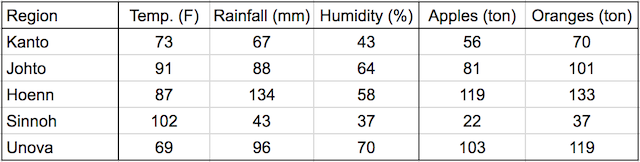

In a linear regression model, each target variable is estimated to be a weighted sum of the input variables, offset by some constant, known as a bias :

yield_apple  = w11 * temp + w12 * rainfall + w13 * humidity + b1
yield_orange = w21 * temp + w22 * rainfall + w23 * humidity + b2
Visually, it means that the yield of apples is a linear or planar function of temperature, rainfall and humidity:

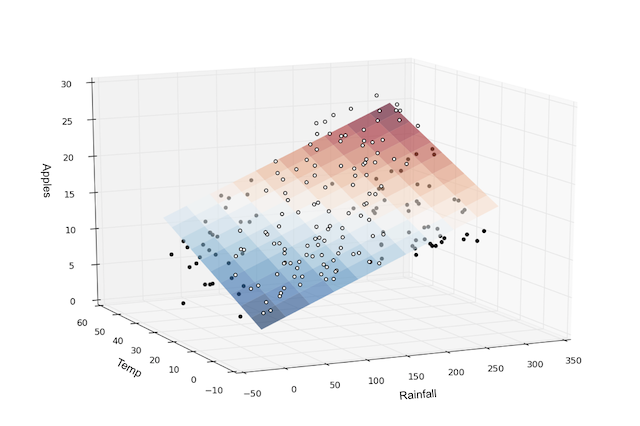

The learning part of linear regression is to figure out a set of weights w11, w12,... w23, b1 & b2 using the training data, to make accurate predictions for new data. The learned weights will be used to predict the yields for apples and oranges in a new region using the average temperature, rainfall, and humidity for that region.

We'll train our model by adjusting the weights slightly many times to make better predictions, using an optimization technique called gradient descent. Let's begin by importing Numpy and PyTorch.

In [1]:
import numpy as np
import torch

## Training data

We can represent the training data using two matrices: inputs and targets, each with one row per observation, and one column per variable.

In [2]:
# Input (temp, rainfall, humidity)
inputs = np.array([[73, 67, 43], 
                   [91, 88, 64], 
                   [87, 134, 58], 
                   [102, 43, 37], 
                   [69, 96, 70]], dtype='float32')

In [3]:
# Targets (apples, oranges)
targets = np.array([[56, 70], 
                    [81, 101], 
                    [119, 133], 
                    [22, 37], 
                    [103, 119]], dtype='float32')

In [4]:
# Convert inputs and targets to tensors
inputs = torch.from_numpy(inputs)
targets = torch.from_numpy(targets)
print(inputs)
print(targets)

tensor([[ 73.,  67.,  43.],
        [ 91.,  88.,  64.],
        [ 87., 134.,  58.],
        [102.,  43.,  37.],
        [ 69.,  96.,  70.]])
tensor([[ 56.,  70.],
        [ 81., 101.],
        [119., 133.],
        [ 22.,  37.],
        [103., 119.]])


## Linear regression model from scratch

The weights and biases (w11, w12,... w23, b1 & b2) can also be represented as matrices, initialized as random values. The first row of w and the first element of b are used to predict the first target variable, i.e., yield of apples, and similarly, the second for oranges.

In [5]:
# Weights and biases
w = torch.randn(2, 3, requires_grad=True)
b = torch.randn(2, requires_grad=True)
print(w)
print(b)

tensor([[-0.2683, -0.7269,  0.8248],
        [-0.9382,  0.3457, -1.8322]], requires_grad=True)
tensor([-0.5134, -0.8917], requires_grad=True)


torch.randn creates a tensor with the given shape, with elements picked randomly from a normal distribution with mean 0 and standard deviation 1.

Our model is simply a function that performs a matrix multiplication of the inputs and the weights w (transposed) and adds the bias b (replicated for each observation).

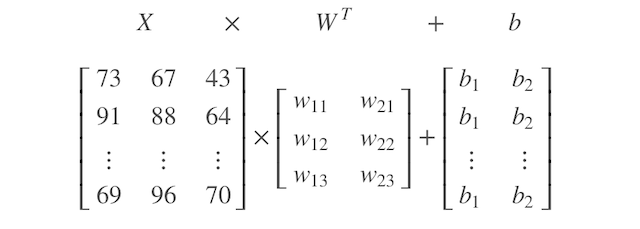

We can define the model as follows:

In [6]:
def model(x):
    return x @ w.t() + b

@ represents matrix multiplication in PyTorch, and the .t method returns the transpose of a tensor.

The matrix obtained by passing the input data into the model is a set of predictions for the target variables.

In [7]:
# Generate predictions
preds = model(inputs)
print(preds)

tensor([[ -33.3361, -125.0090],
        [ -36.1102, -173.1148],
        [ -73.4247, -142.4687],
        [ -28.6182, -149.5203],
        [ -31.0750, -160.7016]], grad_fn=<AddBackward0>)


Let's compare the predictions of our model with the actual targets.

In [8]:
# Compare with targets
print(targets)

tensor([[ 56.,  70.],
        [ 81., 101.],
        [119., 133.],
        [ 22.,  37.],
        [103., 119.]])


You can see a big difference between our model's predictions and the actual targets because we've initialized our model with random weights and biases. Obviously, we can't expect a randomly initialized model to just work.

## Loss function

Before we improve our model, we need a way to evaluate how well our model is performing. We can compare the model's predictions with the actual targets using the following method:

(1) Calculate the difference between the two matrices (preds and targets).

(2) Square all elements of the difference matrix to remove negative values.

(3) Calculate the average of the elements in the resulting matrix.

The result is a single number, known as the mean squared error (MSE).

In [9]:
# MSE loss
def mse(t1, t2):
    diff = t1 - t2
    return torch.sum(diff * diff) / diff.numel()

In [10]:
# Compute loss
loss = mse(preds, targets)
print(loss)

tensor(38133.4531, grad_fn=<DivBackward0>)


Here’s how we can interpret the result: On average, each element in the prediction differs from the actual target by the square root of the loss. And that’s pretty bad, considering the numbers we are trying to predict are themselves in the range 50–200. The result is called the loss because it indicates how bad the model is at predicting the target variables. It represents information loss in the model: the lower the loss, the better the model.

## Compute gradients

With PyTorch, we can automatically compute the gradient or derivative of the loss w.r.t. to the weights and biases because they have requires_grad set to True.

In [11]:
# Compute gradients
loss.backward()

The gradients are stored in the .grad property of the respective tensors. Note that the derivative of the loss w.r.t. the weights matrix is itself a matrix with the same dimensions.

In [12]:
# Gradients for weights
print(w)
print(w.grad)

tensor([[-0.2683, -0.7269,  0.8248],
        [-0.9382,  0.3457, -1.8322]], requires_grad=True)
tensor([[ -9666.7510, -11424.7822,  -6751.0537],
        [-20294.0703, -21794.4453, -13677.2559]])


## Adjust weights and biases to reduce the loss

The loss is a quadratic function of our weights and biases, and our objective is to find the set of weights where the loss is the lowest. If we plot a graph of the loss w.r.t any individual weight or bias element, it will look like the figure shown below. An important insight from calculus is that the gradient indicates the rate of change of the loss, i.e., the loss function's slope w.r.t. the weights and biases.

If a gradient element is positive:

(1) increasing the weight element's value slightly will increase the loss

(2) decreasing the weight element's value slightly will decrease the loss

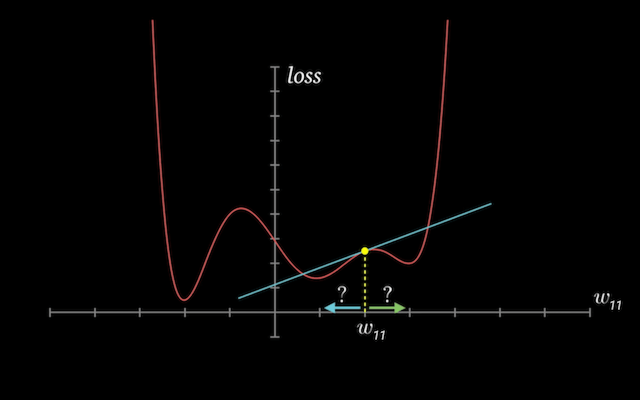

If a gradient element is negative:

(1) increasing the weight element's value slightly will decrease the loss

(2) decreasing the weight element's value slightly will increase the loss

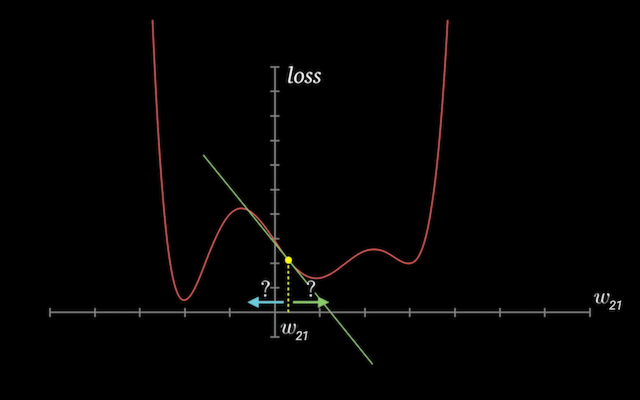

The increase or decrease in the loss by changing a weight element is proportional to the gradient of the loss w.r.t. that element. This observation forms the basis of the gradient descent optimization algorithm that we'll use to improve our model (by descending along the gradient).

We can subtract from each weight element a small quantity proportional to the derivative of the loss w.r.t. that element to reduce the loss slightly.

In [13]:
w
w.grad

tensor([[ -9666.7510, -11424.7822,  -6751.0537],
        [-20294.0703, -21794.4453, -13677.2559]])

In [14]:
with torch.no_grad():
    w -= w.grad * 1e-5
    b -= b.grad * 1e-5

We multiply the gradients with a very small number (10^-5 in this case) to ensure that we don't modify the weights by a very large amount. We want to take a small step in the downhill direction of the gradient, not a giant leap. This number is called the learning rate of the algorithm.

We use torch.no_grad to indicate to PyTorch that we shouldn't track, calculate, or modify gradients while updating the weights and biases.

In [15]:
# Let's verify that the loss is actually lower
loss = mse(preds, targets)
print(loss)

tensor(38133.4531, grad_fn=<DivBackward0>)


Before we proceed, we reset the gradients to zero by invoking the .zero_() method. We need to do this because PyTorch accumulates gradients. Otherwise, the next time we invoke .backward on the loss, the new gradient values are added to the existing gradients, which may lead to unexpected results.

In [16]:
w.grad.zero_()
b.grad.zero_()
print(w.grad)
print(b.grad)

tensor([[0., 0., 0.],
        [0., 0., 0.]])
tensor([0., 0.])


## Train the model using gradient descent

As seen above, we reduce the loss and improve our model using the gradient descent optimization algorithm. Thus, we can train the model using the following steps:

1. Generate predictions

2. Calculate the loss

3. Compute gradients w.r.t the weights and biases

4. Adjust the weights by subtracting a small quantity proportional to the gradient

5. Reset the gradients to zero

Let's implement the above step by step.

In [17]:
# Generate predictions
preds = model(inputs)
print(preds)

tensor([[ -15.7207,  -89.7084],
        [ -12.9378, -126.7122],
        [ -45.7887,  -87.6730],
        [ -11.3464, -114.3857],
        [  -8.7103, -116.1995]], grad_fn=<AddBackward0>)


In [18]:
# Calculate the loss
loss = mse(preds, targets)
print(loss)

tensor(25900.7305, grad_fn=<DivBackward0>)


In [19]:
# Compute gradients
loss.backward()
print(w.grad)
print(b.grad)

tensor([[ -7845.9814,  -9462.3154,  -5541.4575],
        [-16649.8398, -17879.6133, -11261.0635]])
tensor([ -95.1008, -198.9358])


Let's update the weights and biases using the gradients computed above.

In [20]:
# Adjust weights & reset gradients
with torch.no_grad():
    w -= w.grad * 1e-5
    b -= b.grad * 1e-5
    w.grad.zero_()
    b.grad.zero_()

Let's take a look at the new weights and biases.

In [21]:
print(w)
print(b)

tensor([[-0.0931, -0.5181,  0.9477],
        [-0.5688,  0.7424, -1.5828]], requires_grad=True)
tensor([-0.5113, -0.8873], requires_grad=True)


With the new weights and biases, the model should have a lower loss.

In [22]:
# Calculate loss
preds = model(inputs)
loss = mse(preds, targets)
print(loss)

tensor(17655.5664, grad_fn=<DivBackward0>)


We have already achieved a significant reduction in the loss merely by adjusting the weights and biases slightly using gradient descent.

## Train for multiple epochs

To reduce the loss further, we can repeat the process of adjusting the weights and biases using the gradients multiple times. Each iteration is called an epoch. Let's train the model for 100 epochs.

In [23]:
# Train for 100 epochs
for i in range(100):
    preds = model(inputs)
    loss = mse(preds, targets)
    loss.backward()
    with torch.no_grad():
        w -= w.grad * 1e-5
        b -= b.grad * 1e-5
        w.grad.zero_()
        b.grad.zero_()

In [24]:
# Calculate loss
preds = model(inputs)
loss = mse(preds, targets)
print(loss)

tensor(310.8692, grad_fn=<DivBackward0>)


The loss is now much lower than its initial value. Let's look at the model's predictions and compare them with the targets.

In [25]:
# Predictions
preds

tensor([[ 61.1884,  71.8711],
        [ 89.8925,  87.2073],
        [ 94.7439, 161.0632],
        [ 45.4614,  45.4846],
        [100.9632,  90.6014]], grad_fn=<AddBackward0>)

In [26]:
# Targets
targets

tensor([[ 56.,  70.],
        [ 81., 101.],
        [119., 133.],
        [ 22.,  37.],
        [103., 119.]])

The predictions are now quite close to the target variables. We can get even better results by training for a few more epochs.